## Average MRIQC tSNR images in MNI 2009c space

MRIQC normalizes to the MNI 2009c nlin asym 2mm space

AUTHOR : Mike Tyszka  
PLACE  : Catech  
DATES  : 2021-06-30 JMT From scratch

In [2]:
import os
import numpy as np
import nibabel as nib
import ants
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

matplotlib.rcParams["text.usetex"] = True

In [3]:
# Loop over all tSNR images
tsnr_dir = 'tSNR'

for tsnr_fname in sorted(glob(os.path.join('tSNR', '*_tsnr.nii.gz'))):
    
    tsnr_mni_fname = tsnr_fname.replace('_tsnr', '_tsnr_mni')
    
    if not os.path.isfile(tsnr_mni_fname):
    
        print('Processing {}'.format(os.path.basename(tsnr_fname)))
    
        # Corresponding MNI EPI reference
        mniref_fname = tsnr_fname.replace('_tsnr', '_mniref')

        # Load tSNR image in individual space
        tsnr = ants.image_read(tsnr_fname)

        # Load EPI reference in MNI space
        epi_mni = ants.image_read(mniref_fname)

        # Calculate SyN warp from individual to MNI space
        mni_tx = ants.registration(fixed=epi_mni, moving=tsnr, type_of_transform = 'SyN' )

        # Apply SyN transform to individual tSNR image
        tsnr_mni = ants.apply_transforms(fixed=epi_mni, moving=tsnr, transformlist=mni_tx['fwdtransforms'])

        # Save tSNR image in MNI space
        ants.image_write(tsnr_mni, tsnr_mni_fname)

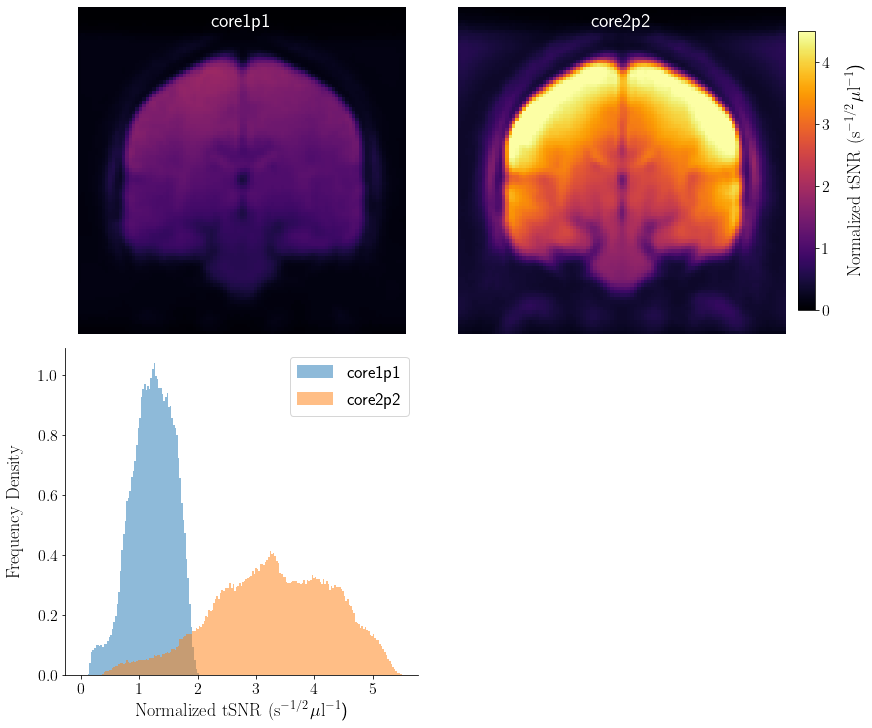

In [5]:
# Create mean (over all available subjects) normalized tSNR images for first and last core protocols
# protocol_names = ['core1p1', 'core1p2', 'core1p3p0', 'core1p3p1', 'core2p2']
protocol_names = ['core1p1', 'core2p2']

# Protocol normalization factors for voxel volume and TR
# f = 1 / (sqrt(TR_secs) * V_vox_ul )
# core1p1 : TR = 2.5 s, voxel = 3 mm iso -> f = 1 / (sqrt(2.5) * 3 * 3 * 3) = 0.0234
norm_factors = {
    'core1p1': 0.0234,
    'core1p2': 0.0640,
    'core1p3p0': 0.0640,
    'core1p3p1': 0.0640,
    'core2p2': 0.0765
}

# MRIQC normalizes to the MNI152 2009c nlin asym 2mm space
# Load a numpy version of the brain mask for histograms below
brain_mask = ants.image_read('tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz').numpy().astype(bool)

# Setup subplot grid for two coronal sections and a histogram
hfont = {'fontname':'Helvetica'}
fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
ax_hist = axs[1, 0]

for pc, prot in enumerate(protocol_names):
    
    tsnr_mean_fname = '{}_tsnr_mean.nii.gz'.format(prot)
    
    if os.path.isfile(tsnr_mean_fname):
        
        norm_tsnr_mean_ai = ants.image_read(tsnr_mean_fname)
        
    else:
        
        fname_list = sorted(glob(os.path.join(tsnr_dir, '*{}*tsnr_mni.nii.gz'.format(prot))))
        n = float(len(fname_list))

        # Initialize running image sum with first image
        tsnr_sum_ai = ants.image_read(fname_list[0])

        for fname in fname_list[1:]:

            tsnr_ai = ants.image_read(fname)
            tsnr_sum_ai = tsnr_sum_ai + tsnr_ai

        # Calculate mean over all subjects and normalize using precalculated factors
        norm_tsnr_mean_ai = (tsnr_sum_ai / n) * norm_factors[prot]

        # Save mean normalized tSNR image for this protocol
        norm_tsnr_mean_ai.to_filename(tsnr_mean_fname)
        
    # Sample tSNR distribution within brain mask
    norm_tsnr_mean = norm_tsnr_mean_ai.numpy()
    
    # Extract coronal section
    nx, ny, nz = norm_tsnr_mean.shape
    hx, hy, hz = int(nx/2), int(ny/2), int(nz/2)
    tsnr_cor = norm_tsnr_mean[:, hy, :]
    
    # Display coronal section
    cor_im = axs[0, pc].imshow(
        tsnr_cor.transpose(),
        origin='lower',
        vmin=0.0,
        vmax=4.5,
        cmap='inferno'
    )
    
    axs[0, pc].axis('off')
    axs[0, pc].set_title(prot, fontsize=20, x=0.5, y=1.0, pad=-20, color='w')
        
    # Extract norm tsnr within brain mask
    tsnr_brain = norm_tsnr_mean[brain_mask]
    
    # Plot overlayed histograms of normalized tSNR
    ax_hist.hist(
        tsnr_brain,
        bins=np.linspace(0, 5.5, 200),
        alpha=0.5,
        density=True
    )
    
# Add coronal section colorbar
cbar = fig.colorbar(cor_im, ax=axs[0, 1], shrink=0.85)
cbar.ax.set_ylabel(r'$\rm{Normalized \ tSNR} \ (s^{-1/2} \mu l^{-1}$)', labelpad=15, fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Add labels and legend to histogram
# Note the Latex rendering
ax_hist.set_xlabel(r'$\rm{Normalized \ tSNR} \ (s^{-1/2} \mu l^{-1}$)', fontsize=18)
ax_hist.set_ylabel(r'$\rm{Frequency \ Density}$', fontsize=18, labelpad=15)
ax_hist.tick_params(axis='x', labelsize=16)
ax_hist.tick_params(axis='y', labelsize=16)
ax_hist.legend(['core1p1', 'core2p2'], fontsize=18)

# Hide histogram top and right spines
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
    
# Hide bottom right subplot axes
axs[1, 1].axis('off')

# Save figure
plt.savefig('Mean_Normalized_tSNR.png', dpi=300)